# Notebook outline

- Context
- Data Understanding
	- Entire dataset
	- Subset of interest
- Data Preparation
	- Feature engineering
	- Data preparation summary
	- Visualize distributions of features and response variables
		- Q1) To what extent do full time developers have a learning mentality?
		- Q2) To what extent do full time developers have a strong social network with other developers?
	- Q1, Q2, and visualization findings
- Data Modeling
	- Q3) How do individual learning mentality and social network strength relate to career satisfaction?	
	- Q3 and general findings 
	- Reduced model with aggregated features
	- Additional Q3 findings
- Results evaluation
    - summary of Q1, Q2, and Q3 findings


# Context

What makes a career satisfying? Two of my favorite things about working in data are the opportunity to continuously learn more about programming languages and to brainstorm with coworkers who feel passionately about the field. With the [2017 Stack Overflow developer survey](https://www.kaggle.com/stackoverflow/so-survey-2017), we can gain insight into whether or not this opinion might be more widespread. Though I’m not a developer, it also seems as though developer languages are also constantly evolving. This notebook will examine the following questions: 

1) To what extent do full time developers have a learning mentality? 

2) To what extent do full time developers have a strong social network with other developers? 

3) How do individual learning mentality and social network strength relate to career satisfaction?


In [322]:
# import necesary packages
import numpy as np
import pandas as pd
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [323]:
# os.chdir("developer_survey_2017")

In [324]:
data_file = "survey_results_public.csv"
desc_file = "survey_results_schema.csv"
df = pd.read_csv(data_file)
df_desc = pd.read_csv(desc_file)

# Data Understanding

## Entire dataset

Before we create a dataframe of interest to answer our questions, let's take a brief look at the entire dataset.

In [325]:
print(df.shape)

(51392, 154)


In [326]:
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Subset of interest
To answer the 3 proposed questions, we're mainly interested in the opinions of professional full-time developers.

In [327]:
# relevant columns to answer our questions
relevant_cols = ['Professional','EmploymentStatus','Country','CompanySize',
                 'YearsCodedJob','ProblemSolving','BuildingThings',
                 'LearningNewTech','InvestTimeTools','ChallengeMyself',
                 'FriendsDevelopers','KinshipDevelopers','CareerSatisfaction',
                'EnjoyDebugging']
df = df[relevant_cols]


In [328]:
# create df with full time employed professional developers
prof_dev = df['Professional']=='Professional developer'
fte = df['EmploymentStatus'] == 'Employed full-time'
df_dev_fte = df[prof_dev & fte]

print("{} out of {} respondents are full-time employed professional developers".format(len(df_dev_fte), len(df)))


30211 out of 51392 respondents are full-time employed professional developers


In [329]:
# drop cols that won't be used in analysis
df_dev_fte.drop(columns=['Professional','EmploymentStatus'], inplace=True)
    # same as below
# df_dev_fte.drop(labels=['Professional','EmploymentStatus'], axis=1, inplace=True)


In [330]:
df_dev_fte.dtypes

Country                object
CompanySize            object
YearsCodedJob          object
ProblemSolving         object
BuildingThings         object
LearningNewTech        object
InvestTimeTools        object
ChallengeMyself        object
FriendsDevelopers      object
KinshipDevelopers      object
CareerSatisfaction    float64
EnjoyDebugging         object
dtype: object

In [331]:
# company size is coded differently
df_dev_fte.CompanySize.value_counts()

20 to 99 employees          6988
100 to 499 employees        5920
10,000 or more employees    4292
10 to 19 employees          3175
1,000 to 4,999 employees    2947
Fewer than 10 employees     2796
500 to 999 employees        1959
5,000 to 9,999 employees    1190
I don't know                 469
I prefer not to answer       438
Name: CompanySize, dtype: int64

In [332]:
missing_data_cols = df_dev_fte.isnull().sum().sort_values()
print("percent missing data in relevant columns:")
round((missing_data_cols/df.shape[0])*100, 2)

percent missing data in relevant columns:


Country                0.00
CompanySize            0.07
YearsCodedJob          0.45
CareerSatisfaction     0.54
LearningNewTech       21.67
ProblemSolving        21.70
BuildingThings        21.73
FriendsDevelopers     21.91
ChallengeMyself       22.03
InvestTimeTools       22.09
KinshipDevelopers     22.32
EnjoyDebugging        23.14
dtype: float64

In [333]:
# Drop columns have a minimal amount of missing data
drop_nas_from_cols = ['Country','CompanySize','YearsCodedJob','CareerSatisfaction']

df_dev_fte.dropna(axis=0, how='any', subset=drop_nas_from_cols, inplace=True)

# remove missing values from CompanySize
companysize_nan1 = df_dev_fte['CompanySize'] != "I don't know"
companysize_nan2 = df_dev_fte['CompanySize'] != "I prefer not to answer"
df_dev_fte = df_dev_fte[companysize_nan1 & companysize_nan2]



In [334]:
# view new percent missing data in relevant columns
missing_data_cols = df_dev_fte.isnull().sum().sort_values()
print("percent missing data in relevant columns:")
round((missing_data_cols/df.shape[0])*100, 2)

percent missing data in relevant columns:


Country                0.00
CompanySize            0.00
YearsCodedJob          0.00
CareerSatisfaction     0.00
LearningNewTech       20.41
ProblemSolving        20.44
BuildingThings        20.46
FriendsDevelopers     20.65
ChallengeMyself       20.72
InvestTimeTools       20.76
KinshipDevelopers     21.00
EnjoyDebugging        21.79
dtype: float64

# Data Preparation

## Feature engineering

In [335]:
def recode_country(x):
    """
    function to create US boolean variable
    
    x: value in pandas series
    """
    
    if x == 'United States':
        return 1
    else: 
        return 0
df_dev_fte['Country'] = df_dev_fte['Country'].apply(recode_country)
df_dev_fte.rename(columns={'Country':'US'}, inplace=True)

In [336]:
CompanySize_mapping = {'Fewer than 10 employees': 1, '10 to 19 employees': 2, 
                       '20 to 99 employees': 3, '100 to 499 employees': 4, 
                       '500 to 999 employees': 5, '1,000 to 4,999 employees': 6,
                       '5,000 to 9,999 employees': 7, '10,000 or more employees': 8}

df_dev_fte['CompanySize'] = df_dev_fte['CompanySize'].replace(CompanySize_mapping)


In [337]:
def recode_YearsCodedJob(x):
    """
    return first 2 characters to get years coded from string
    
    x: value in pandas series
    """
    if x is not None:
        return x[:2]

YearsCoded_mapping = {'Le' : 0}

df_dev_fte['YearsCodedJob'] = df_dev_fte['YearsCodedJob'].apply(recode_YearsCodedJob)
df_dev_fte['YearsCodedJob'] = df_dev_fte['YearsCodedJob'].replace(YearsCoded_mapping)
df_dev_fte['YearsCodedJob'] = pd.to_numeric(df_dev_fte['YearsCodedJob'])

In [338]:
likert_mapping = {'Strongly disagree': 1, 'Disagree': 2, 
                  'Somewhat agree': 3, 'Agree': 4, 'Strongly agree': 5}

likert_cols = ['ProblemSolving', 'BuildingThings', 'LearningNewTech',
               'InvestTimeTools', 'ChallengeMyself', 'FriendsDevelopers',
               'KinshipDevelopers','EnjoyDebugging']

for col in likert_cols: 
    df_dev_fte[col] = df_dev_fte[col].replace(likert_mapping)

In [339]:
# look at rows w/nan values only
df_dev_fte_nans = df_dev_fte[pd.isnull(df_dev_fte).any(axis=1)]

# compare distributions of Career Satisfaction and non null features
df_dev_fte_nans_desc = df_dev_fte_nans.describe()
df_dev_fte_desc = df_dev_fte.describe()

desc_comp = df_dev_fte_nans_desc.merge(df_dev_fte_desc, left_index=True, right_index=True,
                                       suffixes=('_nans','_no_nans') )

desc_comp['CareerSatisfaction_diff'] = desc_comp['CareerSatisfaction_nans'] - desc_comp['CareerSatisfaction_no_nans']
desc_comp['CompanySize_diff'] = desc_comp['CompanySize_nans'] - desc_comp['CompanySize_no_nans']
desc_comp['YearsCodedJob_diff'] = desc_comp['YearsCodedJob_nans'] - desc_comp['YearsCodedJob_no_nans']
desc_comp['US_diff'] = desc_comp['US_nans'] - desc_comp['US_no_nans']





In [340]:
# not a huge difference in statistics for groups with and without missing data

diff_cols = ['CareerSatisfaction_diff','CompanySize_diff','YearsCodedJob_diff','US_diff']
desc_comp[diff_cols][1:]

,CareerSatisfaction_diff,CompanySize_diff,YearsCodedJob_diff,US_diff
mean,-0.037970,-0.030060,-0.261837,-0.016483
std,0.051972,0.002913,-0.092989,-0.010215
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,-1.000000,0.000000
75%,0.000000,0.000000,-1.000000,0.000000
max,0.000000,0.000000,0.000000,0.000000


In [341]:
# drop rows w/any nans
df_dev_fte_no_nans = df_dev_fte.dropna(axis=0, how='any')
print("{} out of {} full-time employed professional developers do not have missing data".format(len(df_dev_fte_no_nans), len(df_dev_fte)))



11619 out of 28879 full-time employed professional developers do not have missing data


## Data preparation summary

- Career Satisfaction and some features CompanySize YearsCodedJob, and US had limited amounts of missing data, so we dropped rows with missing values for these variables

- There was relatively more missing data for the likert variables. We found that Career Satisfaction, CompanySize YearsCodedJob, and US. In general, those with missing likert data have slightly lower career satisfaction, work at slightly smaller companies, have been coding for an average of 3 months less, and are slightly more likely to reside outside the US. Note, the differences here are quite minimal. We also have a fair amount of data for modeling if we drop these rows. Because of that, we'll drop all rows with null values moving forward. 

- add visualizations

- modeling next


## Visualize distributions of features and response variables
In this section, we'll answer questions 1 and 2

## Question 1) To what extent do full time developers have a learning mentality?

## Question 2) To what extent do full time developers have a strong social network with other developers?

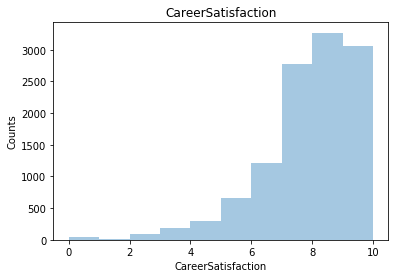

CareerSatisfaction Average:  7.490145451415785


In [342]:
# Career Satisfaction is left skewed
# df_dev_fte_no_nans['CareerSatisfaction'].hist();
sns.distplot(df_dev_fte_no_nans['CareerSatisfaction'], kde=False, bins=10); 
plt.title('CareerSatisfaction')
plt.ylabel('Counts')
plt.show()

print("CareerSatisfaction Average: ", df_dev_fte_no_nans['CareerSatisfaction'].mean())


In [343]:
# # similar satisfaction for US and non-US respondents
# co_hist1 = df_dev_fte_no_nans[df_dev_fte_no_nans['US'] == 0]
# co_hist2 = df_dev_fte_no_nans[df_dev_fte_no_nans['US'] == 1]
# sns.distplot(co_hist1['CareerSatisfaction'], kde=False, bins=10, label='non-United States');
# sns.distplot(co_hist2['CareerSatisfaction'], kde=False, bins=10, label='United States');
# plt.legend()

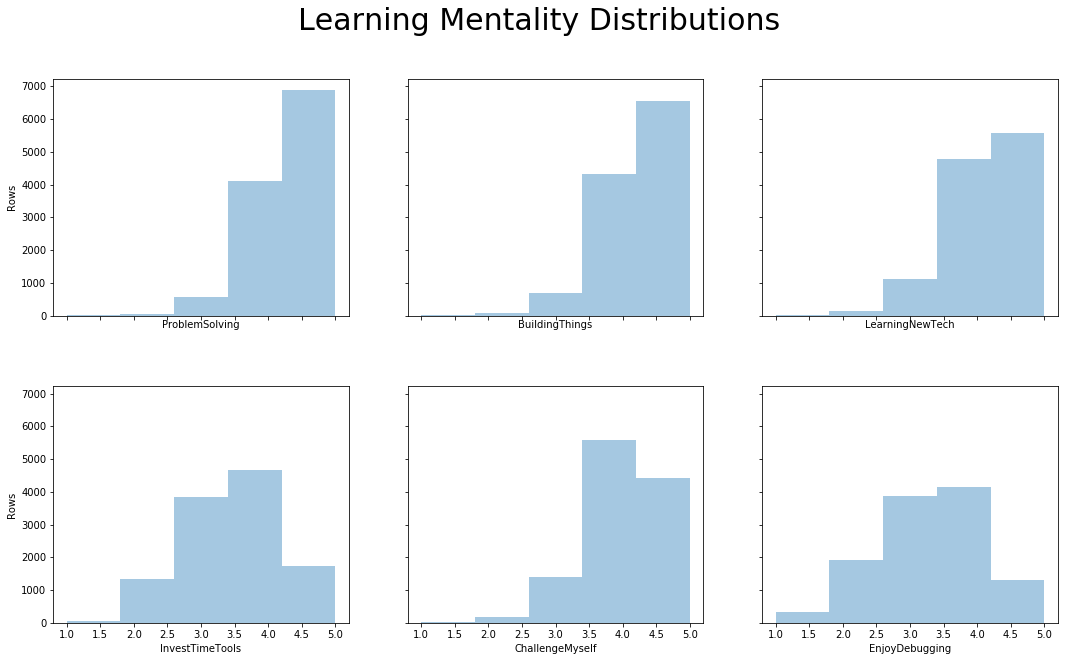

In [344]:
# likert variables (main variables of interest) mostly left-skewed
# df_dev_fte_no_nans[likert_cols].hist(bins=5); 
figure, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize = (18, 10))
figure.suptitle('Learning Mentality Distributions', size=30);
# plt.gca().set_title('LearningMentality Distributions')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
    
sns.distplot(df_dev_fte_no_nans['ProblemSolving'], kde=False, bins=5, ax=axs[0][0]); 
axs[0][0].set_ylabel('Rows') 
sns.distplot(df_dev_fte_no_nans['BuildingThings'], kde=False, bins=5, ax=axs[0][1]); 
sns.distplot(df_dev_fte_no_nans['LearningNewTech'], kde=False, bins=5, ax=axs[0][2]); 
sns.distplot(df_dev_fte_no_nans['InvestTimeTools'], kde=False, bins=5, ax=axs[1][0]); 
axs[1][0].set_ylabel('Rows') 
sns.distplot(df_dev_fte_no_nans['ChallengeMyself'], kde=False, bins=5, ax=axs[1][1]);
sns.distplot(df_dev_fte_no_nans['EnjoyDebugging'], kde=False, bins=5, ax=axs[1][2]);

# sns.distplot(df_dev_fte_no_nans['FriendsDevelopers'], kde=False, bins=5, ax=axs[3][0]); 
# sns.distplot(df_dev_fte_no_nans['KinshipDevelopers'], kde=False, bins=5, ax=axs[3][1]); 



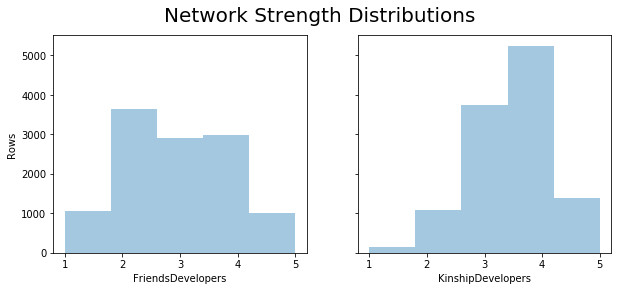

In [345]:
# likert variables (main variables of interest) mostly left-skewed
# df_dev_fte_no_nans[likert_cols].hist(bins=5); 
figure, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize = (10, 4))
figure.suptitle('Network Strength Distributions \n\n', size=20);
# plt.gca().set_title('LearningMentality Distributions')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
    
sns.distplot(df_dev_fte_no_nans['FriendsDevelopers'], kde=False, bins=5, ax=axs[0]);
axs[0].set_ylabel('Rows') 
sns.distplot(df_dev_fte_no_nans['KinshipDevelopers'], kde=False, bins=5, ax=axs[1]); 



In [346]:
# individual plots 
# for col in likert_cols: 
#     sns.distplot(df_dev_fte_no_nans[col], kde=False, bins=5); 
#     plt.show()


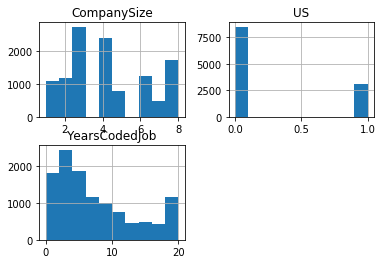

In [347]:
# control variables 
# CompanySize - somewhat normal distribution w/a fair amount of 10k or more employees
# country - mostly non US
# years coded on the job right skewed with a fair amount of 20+ respondents
df_dev_fte_no_nans[['US','CompanySize','YearsCodedJob']].hist();

In [348]:
# similar to heatmap, but not as useful
# sns.pairplot(df_dev_fte_no_nans)

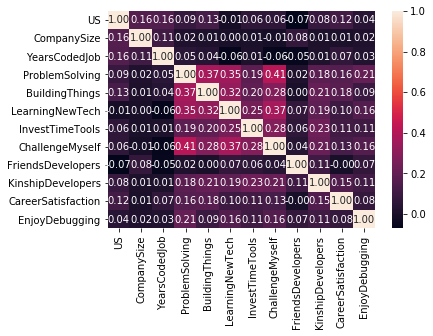

In [349]:
sns.heatmap(df_dev_fte_no_nans.corr(), annot=True, fmt=".2f");

## Q1, Q2, and visualization findings
- Career Satisfaction is left skewed with most of the responses lying on the upper end of the scale (horray!)

- Q1) To what extent do full time developers have a learning mentality? Finding - LearningMentality variables (ProblemSolving, BuildingThings, LearningNewTech, InvestTimeTools, ChallengeMyself, FriendsDevelopers) are relatively left skewed with more full time employed developer respondents favoring a learning mentality. 

- Q2) To what extent do full time developers have a strong social network with other developers? Finding - NetworkStrength variables (KinshipDevelopers, EnjoyDebugging) are relatively normally distributed when compared to LearningMentality variables, indicating less existence of strong networks than existence of learning mentality amongst respondents. 

- LearningMentality variables are relatively more correlated with one another than NetworkStrength variables. 

- Note, since the LearningMentality variables seem to be mostly left skewed, I'm opting to not impute the data to preserve variance for these fields. We do have a fair amount of data points without missing data ~11.6k, so proceeding without imputing values will still leave us with a fair amount of data.


# Data Modeling

## Q3) How do individual learning mentality and social network strength relate to career satisfaction?


In [350]:

def run_lm_model(data, transform_cols, scale_or_normalize): 
    
    """
    inputs: 
        data: dataframe w/X and Y variables of interest. 
            must include CareerSatisfaction as response variable
        transform_cols: columns to apply standard scaler to 
        scale_or_normalize: options - scale or normalize
    return: r2, intercept, coefficients dataframe 
    
    """

    # scale IVs
    # scaler = StandardScaler()  
        # https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc
        # creates a more normal distribution
    
    if scale_or_normalize == 'scale':
        scaler = MinMaxScaler() 
            # use this for coefficient interpretability 
        data = pd.DataFrame.copy(data)
        data[transform_cols] = scaler.fit_transform(data[transform_cols])
    
    if scale_or_normalize == 'normalize':
        normalizer = Normalizer() 
            # use this to approach assumption of normal distribution for IVs
        data = pd.DataFrame.copy(data)
        data[transform_cols] = normalizer.fit_transform(data[transform_cols])


    # create DV and IV dfs
    y = data['CareerSatisfaction'] 
    X = data.drop(columns = ['CareerSatisfaction'])

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 
    
    # use OLS
    lm_model = LinearRegression() # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict and score the model
    y_test_preds = lm_model.predict(X_test) 
    r2 = r2_score(y_test, y_test_preds)
    intercept = lm_model.intercept_

    # create coefficient dataframe for feature importance
    coeff_df = pd.DataFrame(lm_model.coef_, X.columns, 
                        columns = ['Coefficient']) 
    coeff_df['abs_coeff'] = np.abs(coeff_df['Coefficient'])
    coeff_df.sort_values(by=['abs_coeff'], ascending=False, inplace=True)
    
    return r2, intercept, coeff_df, data



In [351]:
# run full model w/scaled data
# transform all cols except for country and careersatisfaction
transform_cols = ['CompanySize','YearsCodedJob', 'ProblemSolving',
                  'BuildingThings','LearningNewTech','InvestTimeTools',
                  'ChallengeMyself','FriendsDevelopers','KinshipDevelopers',
                 'EnjoyDebugging']

r2_s, intercept_s, coeff_df_s, data_s = run_lm_model(data=df_dev_fte_no_nans, 
                                                     transform_cols=transform_cols,
                                                     scale_or_normalize = 'scale')

CareerSatisfaction_mean = df_dev_fte_no_nans['CareerSatisfaction'].describe()['mean']
print("r2: ",r2_s)
print("\nintercept (expected value for those not in US w/mean values: ", intercept_s)
print("CareerSatisfaction mean: ", CareerSatisfaction_mean)
print("\ncoefficients: \n", coeff_df_s) 

r2:  0.06579119329125493

intercept (expected value for those not in US w/mean values:  4.721483326718603
CareerSatisfaction mean:  7.490145451415785

coefficients: 
                    Coefficient  abs_coeff
BuildingThings        0.890613   0.890613
ProblemSolving        0.804116   0.804116
KinshipDevelopers     0.801129   0.801129
InvestTimeTools       0.369352   0.369352
US                    0.307940   0.307940
YearsCodedJob         0.272607   0.272607
ChallengeMyself       0.250551   0.250551
EnjoyDebugging        0.207847   0.207847
LearningNewTech       0.141243   0.141243
FriendsDevelopers    -0.115004   0.115004
CompanySize          -0.084651   0.084651


In [352]:
# run full model w/normalized data
# transform all cols except for country and careersatisfaction
transform_cols = ['CompanySize','YearsCodedJob', 'ProblemSolving',
                  'BuildingThings','LearningNewTech','InvestTimeTools',
                  'ChallengeMyself','FriendsDevelopers','KinshipDevelopers',
                 'EnjoyDebugging']

r2_n, intercept_n, coeff_df_n, data_n = run_lm_model(data=df_dev_fte_no_nans, 
                                                     transform_cols=transform_cols,
                                                     scale_or_normalize = 'normalize')

CareerSatisfaction_mean = df_dev_fte_no_nans['CareerSatisfaction'].describe()['mean']
print("r2: ",r2_n)
print("\nintercept (expected value for those not in US w/mean values: ", intercept_n)
print("CareerSatisfaction mean: ", CareerSatisfaction_mean)
print("\ncoefficients: \n", coeff_df_n) 


r2:  0.02240420659528386

intercept (expected value for those not in US w/mean values:  6.485540862077279
CareerSatisfaction mean:  7.490145451415785

coefficients: 
                    Coefficient  abs_coeff
KinshipDevelopers     2.292429   2.292429
FriendsDevelopers    -0.934797   0.934797
InvestTimeTools       0.886115   0.886115
LearningNewTech      -0.653785   0.653785
YearsCodedJob         0.590549   0.590549
US                    0.434000   0.434000
BuildingThings        0.348291   0.348291
EnjoyDebugging        0.291611   0.291611
ProblemSolving        0.274235   0.274235
CompanySize          -0.267734   0.267734
ChallengeMyself       0.173415   0.173415


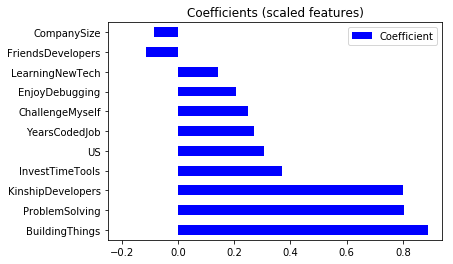

In [353]:
coeff_df_s.plot(y='Coefficient', kind='barh', use_index=True, color='blue',
             xlim=-0.25, title='Coefficients (scaled features)');

## Q3 and general findings
Though normalizing features approaches OLS assumption to a greater extent than min max scaling, scaling the data allows for greater interpretability and higher R-squared (explained variance in CareerSatisfaction). With these likert variables in particluar, interpreability is key to compare coefficients. So, we'll proceed with MinMaxScaling. 

Example interpretations
- MinMaxScaling - When variables are scaled between 1 and 0, a one unit increase in BuildingThings corresponds with a 0.89 increase in CareerSatisfaction.
- Normalization - relatively unknown interpretation

Q3) How do individual learning mentality and social network strength relate to career satisfaction? Finding - With the scaled model, our results indicate that LearningMentality AND NetworkStrength variables are important for CareerSatisfaction. LearningMentality does seem to be slightly more important with BuildingThings and ProblemSolving being more important than KinshipDevelopers. Surprisingly, those who have relatively more friends who are mostly developers have lower CareerSatisfaction.

Let's see if we can simplify this model further.


# Reduced model with aggregated features

In [354]:
# create aggregate variables for LearningMentality and NetworkStrength
    # because individual variables may be capturing similar concepts, affecting results

# BuildingThings and KinshipDevelopers are both the most important
# create df for linear regression w/reduced variables
# create index variables for these learning mentality and network strength
df_dev_fte_no_nans_reduced = pd.DataFrame.copy(df_dev_fte_no_nans)
df_dev_fte_no_nans_reduced['LearningMentality'] = df_dev_fte_no_nans_reduced[['BuildingThings','ProblemSolving','InvestTimeTools','ChallengeMyself','LearningNewTech']].sum(axis=1)
df_dev_fte_no_nans_reduced['NetworkStrength'] = df_dev_fte_no_nans_reduced[['KinshipDevelopers','FriendsDevelopers']].sum(axis=1)

reduced_cols = ['US', 'CompanySize', 'YearsCodedJob','CareerSatisfaction', 
                'LearningMentality', 'NetworkStrength']
df_dev_fte_no_nans_reduced = df_dev_fte_no_nans_reduced[reduced_cols]


In [355]:
reduced_X = ['CompanySize', 'YearsCodedJob',
             'LearningMentality', 'NetworkStrength']
r2_reduced, intercept_reduced, coeff_df_reduced, data_reduced = run_lm_model(data=df_dev_fte_no_nans_reduced, 
                                                                             transform_cols=reduced_X,
                                                                            scale_or_normalize='scale')
print("r2: ",r2_reduced)
print("\nintercept (expected value for those in US w/mean values: ", intercept_reduced)
print("CareerSatisfaction mean: ", CareerSatisfaction_mean)
print("\ncoefficients: \n", coeff_df_reduced) 

r2:  0.05550967143998364

intercept (expected value for those in US w/mean values:  4.952841104302392
CareerSatisfaction mean:  7.490145451415785

coefficients: 
                    Coefficient  abs_coeff
LearningMentality     2.635772   2.635772
NetworkStrength       0.436797   0.436797
US                    0.363798   0.363798
YearsCodedJob         0.324887   0.324887
CompanySize          -0.115835   0.115835


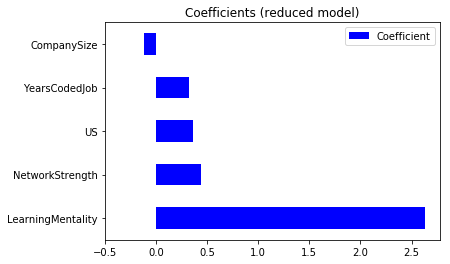

In [356]:
coeff_df_reduced.plot(y='Coefficient', kind='barh', use_index=True, color='blue',
             xlim=-0.5, title='Coefficients (reduced model)');

In [357]:
# # view simple linear regression for main variables of interest

# # transform data
# transform_cols = ['LearningMentality', 'NetworkStrength']
# sc = MinMaxScaler()
# data_scaled = pd.DataFrame.copy(df_dev_fte_no_nans_reduced)
# data_scaled[transform_cols] = sc.fit_transform(data_scaled[transform_cols])

# # jitter allows us to view density
#     # jitter displays values as slightly over max for x and y
# for x in transform_cols:
#     sns.lmplot(x, 'CareerSatisfaction', data_scaled,
#               x_jitter = 0.3, y_jitter=0.3)

## Additional Q3 findings

If we create a more parsimonious model by creating aggregate variables for LearningMentality and NetworkStrength, we observe that LearningMentality has a more substantial relationship with CareerSatisfaction than NetworkStrength. However, the results from the full model indicated this as well when we observed that those who have relatively more friends who are mostly developers have lower CareerSatisfaction.

Let's see what we can learn from creating LearningMentality and NetworkingStrength clusters.

# Career satisfaction for LearningMentality and NetworkingStrength clusters

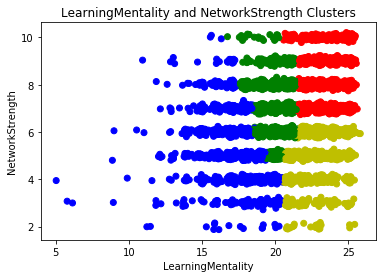

In [358]:

## clustering algo 
estimator = KMeans(n_clusters=4, random_state = 2)
cluster_df = df_dev_fte_no_nans_reduced[['LearningMentality','NetworkStrength']]
estimator.fit(cluster_df)

# Clusters are given in the labels_ attribute
labels = estimator.labels_

# Plot the data
#jitter function to show density of points

# https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(series):
    """
    return series w/jittered values to allow us to view density in scatter plot
    
    series: pandas series
    """
    
    stdev = .01*(max(series)-min(series))
    return series + np.random.randn(len(series)) * stdev

def set_colors(labels, colors='rgbykcm'):
    """
    return a list of colors to be used for scatter plot
    
    labels: numpy array with labels
    colors: colors for plot. labels/clusters will be in this order
    """
    
    colored_labels = []
    for label in labels:
        colored_labels.append(colors[label])
    return colored_labels

# labels: 0-red, 1-green, 2-blue, 3-yellow
    # 0/red - high lm and high nw. Networking learners
    # 1/green - somewhat high lm and high nw. networking moderate-learners
    # 2/blue - low lm and any nw. erratic networking anti-learners 
    # 3/yellow - high lm and lower nw. recluse learners 
colors = set_colors(labels)
plt.scatter(rand_jitter(df_dev_fte_no_nans_reduced['LearningMentality']), rand_jitter(df_dev_fte_no_nans_reduced['NetworkStrength']), c=colors)
plt.title('LearningMentality and NetworkStrength Clusters')
plt.xlabel("LearningMentality")
plt.ylabel("NetworkStrength")
plt.show()

In [359]:
# labels _df
labels_df = pd.DataFrame({"labels":labels, "index":cluster_df.index.tolist()})

# merge to get other features
clusters_df = pd.merge(labels_df, df_dev_fte_no_nans_reduced, how='inner', left_on='index', right_index=True)


# name the labels w/something substantive
def name_labels(x):
    """
    give labels substantive names

    x: value in series
    """
    
    if x == 0:
        return 'networking learners'
    if x == 1: 
        return 'networking moderate-learners'
    if x == 2:
        return 'erratic networking anti-learners'
    if x == 3:
        return 'recluse learners'

clusters_df['cluster'] = clusters_df['labels'].apply(name_labels)     

# drop unnecessary cols
clusters_df.drop(columns=['index', 'LearningMentality','NetworkStrength'], inplace=True)
# clusters_df=pd.get_dummies(data=clusters_df, columns=['labels'])

In [360]:
# create agg data 
clusters_counts = clusters_df['cluster'].value_counts()
clusters_means = clusters_df.groupby(['cluster']).mean()
# merge agg data
clusters_info = pd.merge(clusters_means, pd.DataFrame(clusters_counts), left_index=True, right_index=True)
clusters_info.sort_values(by='CareerSatisfaction', inplace=True)

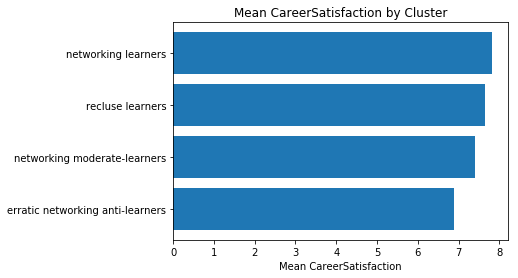

In [362]:
plt.barh(clusters_info.index, clusters_info['CareerSatisfaction'])
plt.title('Mean CareerSatisfaction by Cluster')
plt.xlabel('Mean CareerSatisfaction')
plt.show()

# Q3 cluster findings

- Clustering LearningMentality and NetworkStrength allows use to label users according to these two aggregated dimensions. 

- Networking learners appear to have the highest CareerSatisfaction, followed by recluse learners, networking moderate-learners, then erratic networking anti-learners.

# Results Evaluation
- Q1) To what extent do full time developers have a learning mentality?
    - Based on the left skewed distributions of many learning mentality variable, it appears as though developers have fairly strong learning mentality. 

- Q2) To what extent do full time developers have a strong social network with other developers?
    - Based on the relatively normal distributions of social network variables, developers do not necessarily appear to have a strong social network with other developers. 

- Q3) How do individual learning mentality and social network strength relate to career satisfaction?	
    - Based on a couple linear regression models, we find that both learning mentality and social network variables are important for career satisfaction with the former being more important. 
    - If we cluster developers based on aggregated learning mentality and network strength variables, we find that networking learners have the highest career satisfaction. 